# Water cycle in California's Central Valley

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Warning:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

<p></p>

## Overview

This notebook illustrates the relationship between winter snowfall and soil moisture in California's Central Valley using new publicly available Zarr stores.

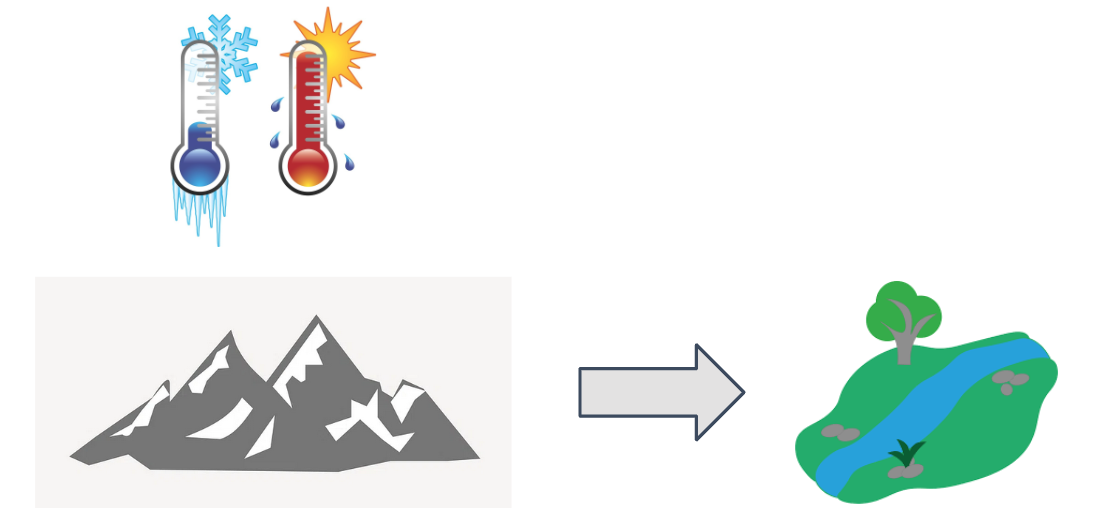

## Prerequisites

This notebook was written using Python 3.10, and requires these libraries and files: 
- netrc file with valid Earthdata Login credentials.
  - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- Xarray
- requests
- S3FS
- Boto3
- NumPy
- Matplotlib
- Pandas
- python-cmr
- re
- Dask
- Folium

## Import Libraries

In [1]:
import boto3
import xarray
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import zarr
import dask
import requests
import pandas as pd
import json
import folium
from IPython.display import display, Markdown
import re
from cmr import VariableQuery


import warnings
warnings.filterwarnings('ignore', message='.*Converting non-nanosecond precision datetime values to nanosecond precision.*')

## Check AWS Region before running notebook

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. Here, we check the region using the Boto3 Python library, and throw a ValueError if you are outside the region.

This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.

In [2]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#x2705;

## Specify the data

### Product
[GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.25 degree V2.0 (GLDAS_NOAH025_3H)](https://disc.gsfc.nasa.gov/datasets/GLDAS_NOAH025_3H_2.0/summary) is a 3-hourly model data product that is part of the NASA Global Land Data Assimilation System Version 2.


* **Shortname:** GLDAS_NOAH025_3H
* **Longname:** GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.25 degree V2.0
* **DOI:** 10.5067/342OHQM9AK6Q
* **Version:** 2.0
* **Spatial Coverage:** -180.0,-60.0,180.0,90.0
* **Temporal Coverage:** 1948-01-01 to  2014-12-31
* **Spatial Resolution:** 0.25 ° x 0.25 °
* **Temporal Resolution:** 3 hours

### Variables 
* **Snowf_tavg** Snow precipitation rate
* **SoilMoi10_40cm_inst**  Soil moisture

In [3]:
product_short_name = "GLDAS_NOAH025_3H"
product_version = "2.0"
snow_var = "/Snowf_tavg"
soil_moisture_10_40_cm_var = "/SoilMoi10_40cm_inst"

## Pick the Location

In [4]:
# Areas we're going to look at: Northern California mountains and Northern Central Valley. 
# These are specified in West,South,East,North form. Negative numbers are West of the prime
# merridian and south of the equator.
valley_bbox = [-122.5, 38.6,-121.4,40.5]
mountain_bbox = [-121.4, 38.6, -120.0, 40.5]

In [5]:
def bbox_to_polygon(bbox):
    """Helper script to convert a bounding box to a polygon"""
    west,south,east,north = bbox
    return [[south,west],[south,east],[north,east],[north,west],[south,west]]

valley_polygon = bbox_to_polygon(valley_bbox)
mountain_polygon = bbox_to_polygon(mountain_bbox)

mid_lat = (valley_bbox[1] + valley_bbox[3])/2
mid_lon = (valley_bbox[0] + mountain_bbox[2])/2

f = folium.Figure(width=500,height=500)
m = folium.Map(location=[mid_lat, mid_lon], zoom_start=6, tiles='OpenStreetMap').add_to(f)

folium.Polygon(locations=valley_polygon, color='red', fill=True, fill_color='red', fill_opacity=0.3).add_to(m)
folium.Polygon(locations=mountain_polygon, color='blue', fill=True, fill_color='blue', fill_opacity=0.3).add_to(m)
m

## Select a Date Range : 1992 - 1993

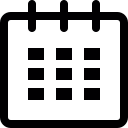

Reference: [Preparing for California's Next Drought: Changes Since 1987-1992](https://water.ca.gov/-/media/DWR-Website/Web-Pages/Water-Basics/Drought/Files/Resources/Preparing-for-california-Next-Drought-1987-92.pdf)

In [6]:
# Hydrological years 1992 and 1993
study_time_range = (np.datetime64('1991-10-01'),np.datetime64('1993-09-30'))

# Equinoxes of those years to help us line up the dates nice
spring_equinox = {
    1992 : np.datetime64('1992-03-20T08:47'),
    1993 : np.datetime64('1993-03-20T14:40')
}
fall_equinox = {
    1992: np.datetime64('1992-09-22T18:42'),
    1993: np.datetime64('1993-09-23T00:22')
}

## Create a function to get the variable metadata from the Common Metadata Respository (CMR)

[CMR](https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/cmr) is Earthdata's metadata repository for all of Earthdata.

In [7]:
def query_all_zarr_stores(provider = None):
    """
    Get all the variable-level zarr stores.

    provider: the archive responsible for this zarr store

    returns: all the variable entries with zarr stores
    """
    api = VariableQuery()
    if provider: 
        all_vars = api.provider(provider).get_all()
    else:
        all_vars = api.get_all()

    zarrs = []
    for variable_entry in all_vars:
        try:
            if variable_entry['instance_information']['format'] == 'zarr':
                zarrs.append(variable_entry)
        except KeyError:
            continue
    return zarrs
    
def find_single_zarr_store(short_name, version, provider = None, variable = None, zarr_stores = None):
    """
    Search for specific zarr stores.

    short_name: the product short name
    version: the product version
    provider: the archive responsible for the zarr store
    variable: path for the variable in this product
    zarr_stores: the result from query_all_zarr_stores. If not specified, the function will go 
       cmr and request all zarr stores again.

    returns: all the zarr stores matching the inputs
    """
    if not zarr_stores:
        zarr_stores = query_all_zarr_stores(provider = provider)
    zarrs = []
    if variable:
        pattern = short_name + '.*' + version + '.*' + variable + '.*'
    else:         
        pattern = short_name + '.*' + version + '.*'

    for store in zarr_stores:
        try:
            if re.match(pattern, store["native_id"]):
                zarrs.append(store)
        except KeyError:
            continue
    return zarrs


## Create a function to open a dataset with xarray using the information from CMR


In [8]:
def get_ds(product_shortname, product_version, variable_name, zarr_stores):
    """
    Open the dataset from s3.

    variable_name: the variable path/name in CMR records
    zarr_stores: the results from calling query_all_zarr_stores()

    return: an xarray dataset for this zarr store
    """

    # Get the entry for this variable
    instance_information = find_single_zarr_store(product_shortname,product_version,variable=variable_name,zarr_stores=zarr_stores)[0]['instance_information']

    # Get temporary credentials. This line will only work if you have setup a .netrc file set up with earthdata login credentials
    # and authorized the GES DISC to use those credentials.
    # (1) Directions for getting a free earthdata login and for authorizing the GES DISC to use your credentials are here: 
    #     https://disc.gsfc.nasa.gov/earthdata-login
    # (2) Directions for setting up a .netrc can be found here:
    #     https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files    
    credentials_endpoint = instance_information['direct_distribution_information']['s_3_credentials_api_endpoint']
    credentials = json.loads(requests.get(credentials_endpoint).text)

    # Open the zarr store
    s3 = s3fs.S3FileSystem(key=credentials["AccessKeyId"], secret=credentials["SecretAccessKey"], token=credentials["SessionToken"])
    store = s3fs.S3Map(root=instance_information['url'], s3=s3, check=False)
    return xarray.open_zarr(store)

# Open the two variables

In [9]:
zarr_stores = query_all_zarr_stores()

In [10]:
%%time
ds_snowfall = get_ds(product_short_name, product_version, snow_var, zarr_stores)
ds_snowfall

CPU times: user 1.89 s, sys: 68.6 ms, total: 1.96 s
Wall time: 14.1 s


<xarray.Dataset> Size: 677GB
Dimensions:           (latitude: 600, bounds: 2, longitude: 1440, time: 196000)
Coordinates:
  * latitude          (latitude) float64 5kB -59.88 -59.62 ... 89.62 89.88
  * longitude         (longitude) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * time              (time) datetime64[ns] 2MB 1948-01-01T03:00:00 ... 1947-...
Dimensions without coordinates: bounds
Data variables:
    latitude_bounds   (latitude, bounds) float64 10kB dask.array<chunksize=(18, 2), meta=np.ndarray>
    longitude_bounds  (longitude, bounds) float64 23kB dask.array<chunksize=(36, 2), meta=np.ndarray>
    time_bounds       (time, bounds) datetime64[s] 3MB dask.array<chunksize=(800, 2), meta=np.ndarray>
    variable          (latitude, longitude, time) float32 677GB dask.array<chunksize=(18, 36, 800), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.10
    DOI:                 10.5067/342OHQM9AK6Q
    product_long_name:   GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.2...
    product_short_name:  GLDAS_NOAH025_3H
    product_version:     2.0

In [11]:
%%time
ds_soil_moisture = get_ds(product_short_name, product_version, soil_moisture_10_40_cm_var,zarr_stores)
ds_soil_moisture

CPU times: user 1.53 s, sys: 53.2 ms, total: 1.58 s
Wall time: 5.58 s


<xarray.Dataset> Size: 677GB
Dimensions:           (latitude: 600, bounds: 2, longitude: 1440, time: 196000)
Coordinates:
  * latitude          (latitude) float64 5kB -59.88 -59.62 ... 89.62 89.88
  * longitude         (longitude) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * time              (time) datetime64[ns] 2MB 1948-01-01T03:00:00 ... 1947-...
Dimensions without coordinates: bounds
Data variables:
    latitude_bounds   (latitude, bounds) float64 10kB dask.array<chunksize=(18, 2), meta=np.ndarray>
    longitude_bounds  (longitude, bounds) float64 23kB dask.array<chunksize=(36, 2), meta=np.ndarray>
    time_bounds       (time, bounds) datetime64[s] 3MB dask.array<chunksize=(800, 2), meta=np.ndarray>
    variable          (latitude, longitude, time) float32 677GB dask.array<chunksize=(18, 36, 800), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.10
    DOI:                 10.5067/342OHQM9AK6Q
    product_long_name:   GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.2...
    product_short_name:  GLDAS_NOAH025_3H
    product_version:     2.0

# Create a function to calculate an area-averaged time series

In [12]:
def area_average(ds,bbox,time_range):
    """
    Builds a dataset with the area average over the bounding box at each time
    in the time range.
    
    ds: dask dataset
    bbox: bounding box in "west,south,east,north" order.
    time_range: tuple of the start and end time

    return: the time series calculation
    """
    
    # parse the bounding box
    west, south, east, north = bbox
    
    # parse the time range
    start_time, end_time = time_range
    
    # subset the data
    time_condition = np.logical_and(ds.time >= start_time, ds.time <=end_time)
    subset = ds.sel(latitude=slice(south,north),longitude=slice(west,east),time=time_condition)
    
    # calculate the weights. Note that because latitude lines come together at the poles, the area
    # of each grid cell gets smaller as the grid cells get closer to the poles. These weights adjust
    # for the size of the grid cells.
    lat_weights = np.cos(np.pi*subset.latitude/180.0)
    
    # project the weights onto an array that is the same shape as the subset
    lat_weights = np.logical_not(np.isnan(subset["variable"]))*lat_weights
    
    # calculate the average
    avg = (lat_weights * subset["variable"]).sum(dim=('latitude','longitude'))/lat_weights.sum(dim=('latitude','longitude'))
    
    return avg.rename("time_series")

# Create functions to work with the snow data

For the snow data, the 3-hourly temporal resolution makes seeing the seasonal variation harder to see. So we're going to accumulate it over each month before plotting

In [13]:
def get_monthly_accumulation(ds,bbox,time_range,rate_factor):
    """
    Calculate monthly accumulations of the area-averaged time series.

    ds: dask dataset
    bbox: the bounding box in "west,south,east,north" order
    time_range: tuple of the start and end time
    rate_factor: how much each value needs to be scaled so it can be converted from a
       rate into an absolute value for the time period

    returns dataframe with the monthly accumulation
    """

    # get the area average
    avg = area_average(ds,bbox,time_range)
    # convert to a dataframe
    df = avg.to_dataframe()
    # multiply the data by the rate factor to convert it from a rate
    df["time_series"] = df["time_series"]*rate_factor
    # accumulate over each month group
    return df.groupby(pd.Grouper(freq="ME")).sum()

def bbox_to_str(bbox):
    """
    Helper function to make the bounding box more human readable.
    """
    def val_to_str(val,neg,pos):
        return f"{abs(val)}" + ( neg if val < 0 else pos)

    return val_to_str(bbox[0],"W","E") + "," + val_to_str(bbox[1],"S","N") + "," + val_to_str(bbox[2],"W","E") + "," + val_to_str(bbox[3],"S","N") 

def plot_monthly_snow_accumulation(ds,bbox,time_range):
    """
    Plot the GLDAS_NOAH025_3H v.2.0 Snowf_tavg variable as a monthly accumulation.

    ds: the dask dataset
    bbox: the bounding box in "west,south,east,north" order
    time_range: tuple of the start and end time
    """
    rate_factor = 3*60*60
    monthly_acc = get_monthly_accumulation(ds,bbox,time_range, rate_factor)
    plt.plot(monthly_acc.index, monthly_acc.time_series,label="Monthly snow (kg m-2)")
    plt.xticks(ticks=monthly_acc.index[0::5],labels=[f"{ind.year}-{ind.month:02d}" for ind in monthly_acc.index[0::5]]);
    title = f"Monthly accumulation of {ds.variable.long_name} [{ds.attrs['product_short_name']} v{ds.attrs['product_version']}]\n"+ \
        f"over region {bbox_to_str(bbox)}, northern California mountains"
    plt.title(title)
    # note that we can't use the original units for the y label because we've accumulated over the month, so this is no longer
    # a rate in seconds
    plt.ylabel(ds.variable.attrs['units'].replace("s-1","month-1"))
    plt.show()

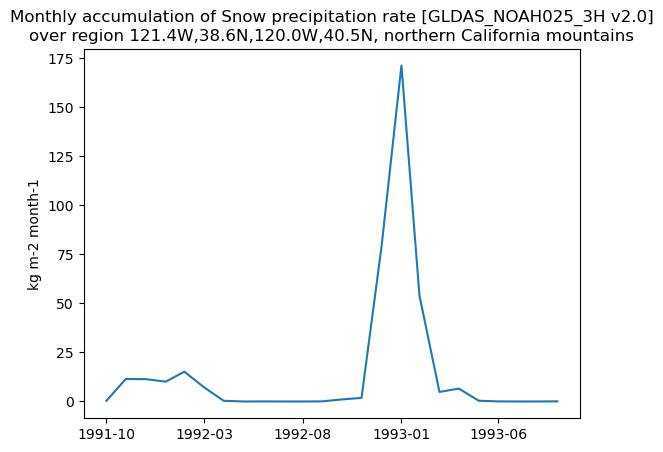

CPU times: user 848 ms, sys: 108 ms, total: 957 ms
Wall time: 1.23 s


In [14]:
%%time
plot_monthly_snow_accumulation(ds_snowfall,mountain_bbox,study_time_range)

# Calculate the soil moisture over the valley

In [15]:
def plot_soil_moisture(ds,bbox,years,spring_equinox,fall_equinox, cutoff):
    """
    Plot the soil moisture in volumetric water content faction over two years.

    ds: soil moisture dataset
    bbox: bounding box for calculation in W,S,E,N format
    years: array of two years for soil moisture
    spring_equinox: dict with the dates for the spring equinoxes
    fall_equinox: dict with the dates for the fall equinoxes
    cutoff: volumetric water content fraction cutoff for the plot 
    """

    # Calculate an area average over the specified bounding box for the time range of the two years specified
    # Convert that area average from kg m-2 to volumetric water content fraction. LDAS documentions this calculation
    # here: https://ldas.gsfc.nasa.gov/faq/nca-ldas. This soil moisture layer is 10-40 cm, which 300 mm.
    aa = area_average(ds,bbox,(np.datetime64(f"{years[0]}-01-01"),np.datetime64(f"{years[1]}-12-31"))).compute()/300
    
    fig,ax = plt.subplots(nrows=2,ncols=1)
    for i in range(2):
        year = years[i]
        spring_through_summer = aa[np.logical_and(aa.time >= spring_equinox[year],aa.time <= fall_equinox[year])]
        ind_cutoff = np.where(spring_through_summer < cutoff)[0][0]
        ax[i].plot(spring_through_summer.time, spring_through_summer)
        ax[i].hlines(y=cutoff, xmin=spring_through_summer.time[0],xmax=spring_through_summer.time[ind_cutoff],linewidth=1,color='k',linestyle='dashed')
        ax[i].vlines(x=spring_through_summer.time[ind_cutoff],ymin=0,ymax=spring_through_summer[ind_cutoff],linewidth=1,color='k',linestyle='dashed')
        ax[i].set_ylabel("volumetric water\ncontent fraction")
        ax[i].set_ylim([0, 0.45])
        timestamp = pd.Timestamp(spring_through_summer.time[ind_cutoff].values).strftime('%Y-%m-%d')
        ax[i].text(spring_through_summer.time[ind_cutoff],cutoff+0.05, f"Soil moisture falls below {cutoff}\non {timestamp}")
        if i == 0:
            title = f"{ds.variable.long_name} [{ds.attrs['product_short_name']} v{ds.attrs['product_version']}]\n" + \
                f"averaged over {bbox_to_str(bbox)}, northern California Central Valley"
            ax[i].set_title(title)
    

CPU times: user 644 ms, sys: 59.5 ms, total: 703 ms
Wall time: 964 ms


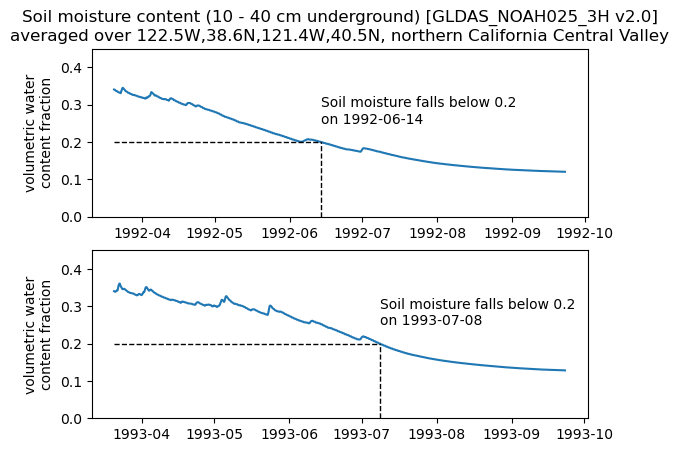

In [16]:
%%time
plot_soil_moisture(ds_soil_moisture,valley_bbox,[1992,1993],spring_equinox,fall_equinox,.2)